#**Naive Bayes (Scratch)**

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.datasets import load_diabetes, load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, explained_variance_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

**Code**

In [2]:
class NaiveBayes:
  def __init__(self, distribution='gaussian', laplace_smoothing=1.0):
    self.distribution = distribution
    self.laplace_smoothing = laplace_smoothing
    self.class_priors = {}
    self.feature_params = {}

  def fit(self, X, y):
    self.classes = np.unique(y)
    n_samples, n_features = X.shape
    for cls in self.classes:
        X_cls = X[y == cls]
        self.class_priors[cls] = len(X_cls) / n_samples
        if self.distribution == 'gaussian':
            if X_cls.size == 0:
                raise ValueError(f"No samples for class {cls}.")
            self.feature_params[cls] = {
                'mean': np.mean(X_cls, axis=0),
                'var': np.var(X_cls, axis=0) + 1e-9  # Adding small value to avoid division by zero
            }
        elif self.distribution == 'multinomial':
            self.feature_params[cls] = {
                'counts': np.sum(X_cls, axis=0),
                'total': len(X_cls)
            }
        elif self.distribution == 'bernoulli':
            self.feature_params[cls] = {
                'prob': (np.sum(X_cls, axis=0) + self.laplace_smoothing) / (len(X_cls) + 2 * self.laplace_smoothing)  # Laplace smoothing
            }

  def predict(self, X):
    n_samples = X.shape[0]
    log_probs = np.zeros((n_samples, len(self.classes)))
    for idx, cls in enumerate(self.classes):
        log_probs_cls = np.log(self.class_priors[cls])
        if self.distribution == 'gaussian':
            mean = self.feature_params[cls]['mean']
            var = self.feature_params[cls]['var']
            log_probs_cls += -0.5 * np.sum(np.log(2 * np.pi * var))
            log_probs_cls += -0.5 * np.sum(((X - mean) ** 2) / var, axis=1)
        elif self.distribution == 'multinomial':
            counts = self.feature_params[cls]['counts']
            total = self.feature_params[cls]['total']
            if X.ndim == 1:
                X = X.reshape(1, -1)  # Ensure 2D array
            prob = (counts + self.laplace_smoothing) / (total + len(counts) * self.laplace_smoothing)
            log_probs_cls += np.sum(X @ np.log(prob).reshape(-1, 1), axis=1)
        elif self.distribution == 'bernoulli':
            prob = self.feature_params[cls]['prob']
            if X.ndim == 1:
                X = X.reshape(1, -1)  # Ensure 2D array
            log_probs_cls += np.sum(X * np.log(prob) + (1 - X) * np.log(1 - prob), axis=1)
        log_probs[:, idx] = log_probs_cls
    log_probs -= np.logaddexp.reduce(log_probs, axis=1)[:, np.newaxis]
    return self.classes[np.argmax(log_probs, axis=1)]

  def accuracy(self, y_true, y_pred):
    return np.mean(y_true == y_pred)

  def precision(self, y_true, y_pred):
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))
    return true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0

  def recall(self, y_true, y_pred):
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))
    return true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0

  def f1_score(self, y_true, y_pred):
    prec = self.precision(y_true, y_pred)
    rec = self.recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

**Load Dataset**

In [3]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

In [4]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105, 4), (45, 4), (105,), (45,))

**Gaussian NB**

In [5]:
# Train and predict with Gaussian Naive Bayes
nb_gaussian = NaiveBayes(distribution='gaussian')
nb_gaussian.fit(X_train, y_train)
predictions_gaussian = nb_gaussian.predict(X_test)
print("Gaussian Naive Bayes Accuracy:", nb_gaussian.accuracy(y_test, predictions_gaussian))
print("Gaussian Naive Bayes F1 Score:", nb_gaussian.f1_score(y_test, predictions_gaussian))

Gaussian Naive Bayes Accuracy: 0.9777777777777777
Gaussian Naive Bayes F1 Score: 1.0


**Multinomial NB**

In [6]:
# Prepare data for Multinomial Naive Bayes
X_train_multinomial = X_train > 0  # Convert to binary for Multinomial
X_test_multinomial = X_test > 0    # Convert to binary for Multinomial
nb_multinomial = NaiveBayes(distribution='multinomial', laplace_smoothing=1.0)
nb_multinomial.fit(X_train_multinomial, y_train)
predictions_multinomial = nb_multinomial.predict(X_test_multinomial)
print("Multinomial Naive Bayes Accuracy:", nb_multinomial.accuracy(y_test, predictions_multinomial))
print("Multinomial Naive Bayes F1 Score:", nb_multinomial.f1_score(y_test, predictions_multinomial))

Multinomial Naive Bayes Accuracy: 0.28888888888888886
Multinomial Naive Bayes F1 Score: 0.5777777777777777


**Bernoulli NB**

In [7]:
# Prepare data for Bernoulli Naive Bayes
X_train_bernoulli = X_train > 0  # Convert to binary for Bernoulli
X_test_bernoulli = X_test > 0    # Convert to binary for Bernoulli
nb_bernoulli = NaiveBayes(distribution='bernoulli', laplace_smoothing=1.0)
nb_bernoulli.fit(X_train_bernoulli, y_train)
predictions_bernoulli = nb_bernoulli.predict(X_test_bernoulli)
print("Bernoulli Naive Bayes Accuracy:", nb_bernoulli.accuracy(y_test, predictions_bernoulli))
print("Bernoulli Naive Bayes F1 Score:", nb_bernoulli.f1_score(y_test, predictions_bernoulli))

Bernoulli Naive Bayes Accuracy: 0.28888888888888886
Bernoulli Naive Bayes F1 Score: 0.5777777777777777


**Visualization**

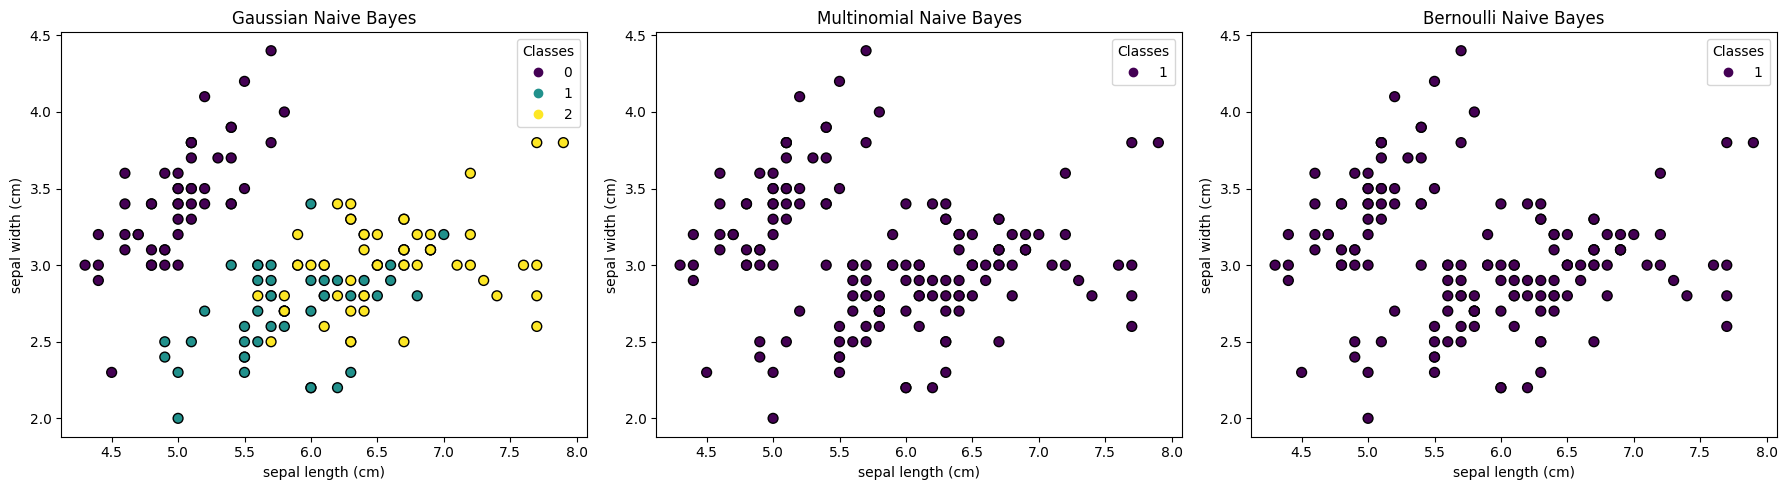

In [8]:
# Visualization
distributions = ['gaussian', 'multinomial', 'bernoulli']
models = [nb_gaussian, nb_multinomial, nb_bernoulli]
X_full = X  # Full dataset for visualization
y_full = y

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, distribution, model in zip(axes, distributions, models):
    # Predict on the entire dataset for visualization
    y_pred_full = model.predict(X_full)

    # Plot the data points
    scatter = ax.scatter(X_full[:, 0], X_full[:, 1], c=y_pred_full, cmap='viridis', edgecolor='k', s=50)
    ax.set_title(f'{distribution.capitalize()} Naive Bayes')
    ax.set_xlabel(iris.feature_names[0])
    ax.set_ylabel(iris.feature_names[1])
    ax.legend(*scatter.legend_elements(), title="Classes")

plt.tight_layout()
plt.show()